# Time delay embedding modified:

Method derived from "Predicting physical variables in time-delay embedding : https://synbio.ucsd.edu/lev/papers/predict.pdf".

Idea: Predict $r*$ when having only $v*$ using regression on neighbours of $v^*[t]$ in a set of simulated series $(v^i, r^i)$. Case $i=1,...10$ and $i=1,...100$.

In [21]:
import os
import sys
import time
import json
import numpy as np
import scipy as sci
import pylab as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cmdstanpy
import arviz as az

from sklearn.metrics import mutual_info_score
from sklearn.neighbors import NearestNeighbors 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from scipy.signal import savgol_filter

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

%pylab inline
plt.style.use('seaborn-talk')
sns.set(style="white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

Populating the interactive namespace from numpy and matplotlib


/home/tng/.local/lib/python3.10/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
pwd

'/home/tng/Documents/montbrio/benchmark_NEW'

In [4]:
cwd = os.getcwd()
cwd

'/home/tng/Documents/montbrio/benchmark_NEW'

In [5]:
#cmdstanpy.install_cmdstan()
#Setting the path for cmdstan
import cmdstanpy
#cmdstanpy.set_cmdstan_path('/home/tng/.cmdstan/cmdstan-2.31.0')
#cmdstanpath = cmdstanpy.cmdstan_path()

In [6]:
def takensEmbedding (data, delay, dimension):
    "This function returns the Takens embedding of data with delay into dimension, delay*dimension must be < len(data)"
    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceed length of data!')    
    embeddedData = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embeddedData = np.append(embeddedData, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embeddedData;

In [7]:
def symmetric_embedding(data, delay, dimension) :
    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceed length of data!')  
    D = dimension // 2
    D_end = D+1 
    if dimension % 2 == 0 : 
        D_end = D   
    len_y = len(data) - (D_end*delay) - (D*delay) + 1
    y = 100 * np.ones((len_y, dimension)) #init to high values to test if embedding is flawed
        
    for i in range(D*delay, len(data)-(delay*D_end)+1) :
        for k in range(-D, D_end) :
            y[i-(D*delay), k] = data[i + k*delay]
    return y

False NN and MI from https://www.kaggle.com/code/tigurius/introduction-to-taken-s-embedding/notebook
They are methods to select the hyperparameters for the embedding: D: embedding dimension = number of time lags = 12; T = time lag size = 160. We do not apply them here.

In [8]:
def mutualInformation(data, delay, nBins):
    "This function calculates the mutual information given the delay"
    I = 0;
    xmax = max(data);
    xmin = min(data);
    delayData = data[delay:len(data)];
    shortData = data[0:len(data)-delay];
    sizeBin = abs(xmax - xmin) / nBins;
    #the use of dictionaries makes the process a bit faster
    probInBin = {};
    conditionBin = {};
    conditionDelayBin = {};
    for h in range(0,nBins):
        if h not in probInBin:
            conditionBin.update({h : (shortData >= (xmin + h*sizeBin)) & (shortData < (xmin + (h+1)*sizeBin))})
            probInBin.update({h : len(shortData[conditionBin[h]]) / len(shortData)});
        for k in range(0,nBins):
            if k not in probInBin:
                conditionBin.update({k : (shortData >= (xmin + k*sizeBin)) & (shortData < (xmin + (k+1)*sizeBin))});
                probInBin.update({k : len(shortData[conditionBin[k]]) / len(shortData)});
            if k not in conditionDelayBin:
                conditionDelayBin.update({k : (delayData >= (xmin + k*sizeBin)) & (delayData < (xmin + (k+1)*sizeBin))});
            Phk = len(shortData[conditionBin[h] & conditionDelayBin[k]]) / len(shortData);
            if Phk != 0 and probInBin[h] != 0 and probInBin[k] != 0:
                I -= Phk * math.log( Phk / (probInBin[h] * probInBin[k]));
    return I;

In [9]:
def false_nearest_neighours(data,delay,embeddingDimension):
    "Calculates the number of false nearest neighbours of embedding dimension"    
    embeddedData = takensEmbedding(data,delay,embeddingDimension);
    #the first nearest neighbour is the data point itself, so we choose the second one
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embeddedData.transpose())
    distances, indices = nbrs.kneighbors(embeddedData.transpose())
    #two data points are nearest neighbours if their distance is smaller than the standard deviation
    epsilon = np.std(distances.flatten())
    nFalseNN = 0
    for i in range(0, len(data)-delay*(embeddingDimension+1)):
        if (0 < distances[i,1]) and (distances[i,1] < epsilon) and ( (abs(data[i+embeddingDimension*delay] - data[indices[i,1]+embeddingDimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN

# The Montbrio model

$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $


In [10]:
def MontbrioFlow(x, t, delta, eta, J, I0):
    Fr=(delta/np.pi) +(2*x[0]*x[1])
    Fv=(x[1]**2)  -(np.pi*x[0])**2 + J*x[0]+ eta +I0
    F=np.array([Fr, Fv])
    return F

def plot_vector_field(ax, param, xrange, yrange, steps=1000):
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    dx,dy = MontbrioFlow([X,Y],0,**param)   
    ax.streamplot(X,Y,dx, dy, density=2.0, color='lightgray')
    ax.contour(X,Y,dx, [0], linestyles='--', linewidths=3, colors="lime", alpha=0.9, zorder=4)
    ax.contour(X,Y,dy, [0], linestyles='--', linewidths=3, colors="cyan", alpha=0.9, zorder=4)
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

# Load simulated series
100 simulated series $(v, r)$ from Montbrio with different parameters and $\sigma = 0.1$ 
See Notebook MPR_NMM_MultipleSyntheticData_forTimeDelayEmbeddingRegression to generate them.

In [11]:
N_series = 100 #series are in files data_input_(0:N_series)
sim_sigma = 0.1

In [12]:
data_input_filename = str('data_input_')
data_input_path = cwd +'/Res_syntheticData/data_input_files/for_timedelay/'

In [13]:
series_list = [] #list of time series, each time serie is in a dict

for i_series in range(N_series):
    data_input = dict(load(data_input_path + data_input_filename + str(i_series) + '.R.npz'))
    
    nt = int(data_input['nt'])
    dt = float(data_input['dt'])
    
    Ts = data_input['ts']
    vs = data_input['vs']
    rs = data_input['rs']
    
    I_input = data_input['I_input']
    I0 = data_input['I0']

    delta_true = float(data_input['delta_true'])
    eta_true = float(data_input['eta_true'])
    J_true = float(data_input['J_true'])
    
    series_list.append(dict(nt=nt, dt=dt, Ts=Ts, vs=vs, rs=rs, I_input=I_input, I0=I0,
                            delta_true=delta_true, eta_true=eta_true, J_true=J_true))

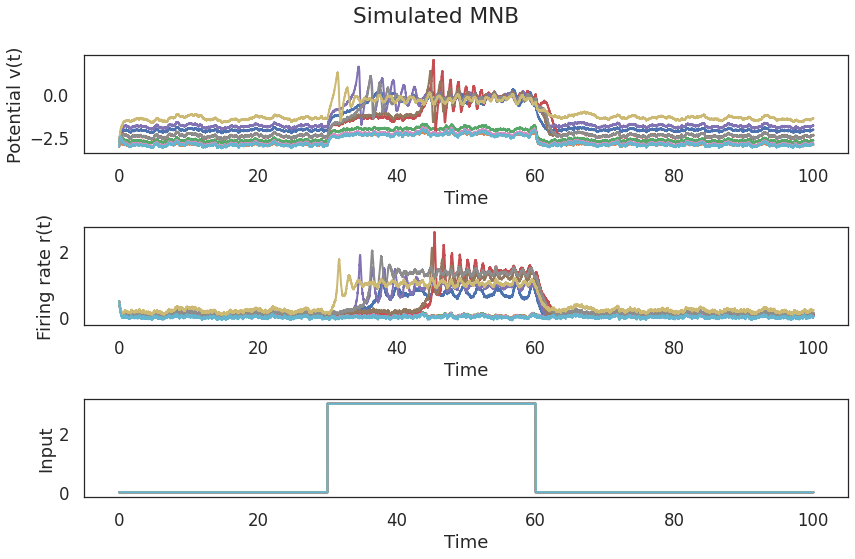

In [14]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 8))

for i in range(10) :
    serie = series_list[i]
    ax[0].plot(serie['Ts'], serie['vs'], linewidth=2)
    ax[1].plot(serie['Ts'], serie['rs'], linewidth=2)
    ax[2].plot(serie['Ts'], serie['I_input'], '-', linewidth=2)
    
ax[0].set(xlabel='Time', ylabel='Potential v(t)') 
ax[1].set(xlabel='Time', ylabel='Firing rate r(t)')
ax[2].set(xlabel='Time', ylabel='Input');
fig.suptitle('Simulated MNB')
fig.tight_layout();

# Load data

We load the original data. We assume we have access only to $v$ and not $r$.

In [15]:
data_sigma = 0.1

In [16]:
data_input_filename=str('data_input_mpr_sd_sigma=' + str(data_sigma))
data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'


In [17]:
data_input = dict(np.load(data_input_path))

In [18]:
v_obs, r_obs = data_input['vs'], data_input['rs']

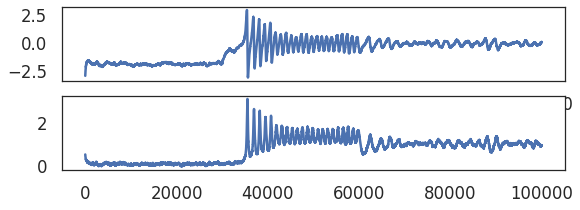

In [19]:
fig, ax = plt.subplots(nrows=2, figsize=(9, 3))
ax[0].plot(v_obs)
ax[1].plot(r_obs)
plt.show()

# Time delay embedding 
with parameters D: embedding dimension = number of time lags = 12; T = time lag size = 160.

In [20]:
T = 160 ; d = 12

**of simulated series:**

In [21]:
#data available: v
vs_list = [np.array(serie['vs']) for serie in series_list] #simulated 'v' series
y_list = []
for l in range(N_series) :
    x = vs_list[l]
    y = symmetric_embedding(x, T, d)
    y_list.append(y)

#data not available: r
z_list = []
for l in range(N_series):
    rs = series_list[l]['rs']
    z = rs[:len(rs)-T*d+1]
    z_list.append(z)

**of original series:**

In [22]:
#data available: v
y_obs = symmetric_embedding(v_obs, T, d)
#data not available: r
z_obs = r_obs[:len(r_obs)-T*d+1]

In [23]:
np.array_equal(y_obs[:, d//2], v_obs[:len(r_obs)-T*d+1])

True

In [24]:
np.save('results/y_obs', y_obs)

# Nearest Neighbours method among the set of $N_{series}$ simulated series.
When we have a serie with only $(v,)$, infer $r$ with the method of regression with neighbours on time delays in a set of simulated (v, r) series. Series simulated with different parameters $\delta, \eta, J$ within a defined range. First I used the original $(d+1)(d+2)$ number of neighbours multiplied by the number of time series, but the latter is probably overkill and computationnaly too expensive for large numbers of series. It works as fine keeping the $(d+1)(d+2)$ neighbours accross the whole set.

In [25]:
N_series_reg = 100 #number of simulated series to use for regression

Text(80, 2, 'rmse=0.176')

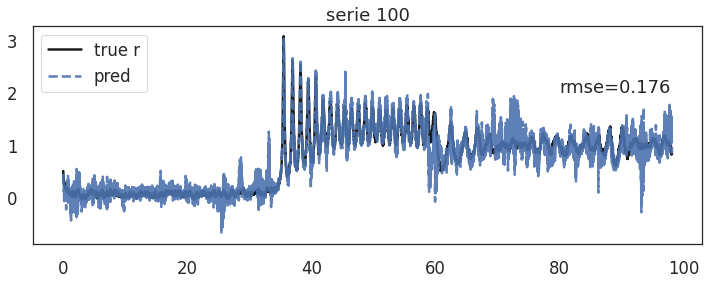

In [26]:
fig, ax = plt.subplots(1, figsize=(12,4))

np.random.seed(0)
y_train = np.array(y_list)[:N_series_reg, :].reshape(-1, y_obs.shape[1]) #ytrain is simulated series
y_test = y_obs # ytest is observed serie
z_train, z_test =  np.array(z_list)[:N_series_reg].flatten(), z_obs

#find the N_b nearest neighbours of y_test points in y_train
N_b = (d+1)*(d+2)
neigh = NearestNeighbors(n_neighbors=N_b+1, algorithm='kd_tree').fit(y_train)
n_distances, n_indices = neigh.kneighbors(y_test)

yk = 10 * np.ones((N_b,) + y_test.shape) #init high to see problems
zk = 10 * np.ones((N_b,) + z_test.shape)
for k in range(1, N_b+1) :
    yk[k-1, :, :] = y_train[n_indices[:, k], :]
    zk[k-1, :] = z_train[n_indices[:, k]]

poly = PolynomialFeatures(degree=1, include_bias=True)
coefs = []
pred = []
pred_train = []

for i in range(len(y_test)) :
    poly_features_yki = poly.fit_transform(yk[:, i, :])
    poly_reg_model = LinearRegression().fit(poly_features_yki, zk[:, i])
    coefs.append(poly_reg_model.coef_)

    poly_features_ytest = poly.fit_transform(y_test[i, :].reshape(1, -1))
    pred.append(poly_reg_model.predict(poly_features_ytest))

coefs = np.array(coefs)    
pred = np.array(pred).reshape(z_test.shape)
rmse_fit = np.sqrt(mean_squared_error(z_test, pred))

Ts = data_input['ts']
ax.plot(Ts[:len(r_obs)-T*d+1], z_obs, '-k', label='true r')
ax.plot(Ts[:len(r_obs)-T*d+1], pred, '--', label='pred', alpha=0.9)
ax.legend(loc='upper left')
ax.set(title='serie ' + str(l+1))
ax.text(80, 2, 'rmse='+str(np.round(rmse_fit, 3)))

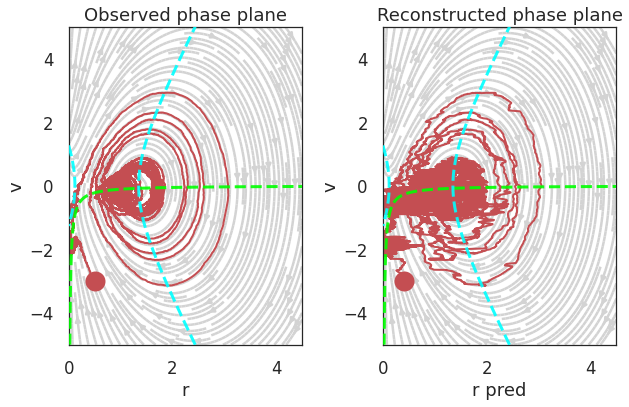

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 6))

param={"delta": data_input['delta_true'], "eta": data_input['eta_true'], "J": data_input['J_true'], 
       "I0": data_input['I0']}

plane_lim = 5
xrange = (0, plane_lim-0.5) 
yrange =(-plane_lim, plane_lim)
plot_vector_field(ax[0], param, xrange, yrange)
plot_vector_field(ax[1], param, xrange, yrange)

ax[0].plot(r_obs, v_obs, marker="o", markersize=0, lw=2, color='r', zorder=2)
ax[0].plot(r_obs[0], v_obs[0], marker="o", markersize=20, lw=0, color='r', zorder=3)
ax[0].set(xlabel='r',  ylabel='v', title="Observed phase plane")

ax[1].plot(pred, v_obs[:len(v_obs)-T*d+1], marker="o", markersize=0, lw=2, color='r', zorder=2)
ax[1].plot(pred[0], v_obs[:len(v_obs)-T*d+1][0], marker="o", markersize=20, lw=0, color='r', zorder=3)
ax[1].set(xlabel='r pred', ylabel='v',
      title="Reconstructed phase plane")
plt.tight_layout()

In [28]:
data_output = {'T': T, 'd': d, 'r': list(r_obs), 'v': list(v_obs), 'r_recons': list(pred), 
               'sim_sigma': sim_sigma,
               'data_sigma': data_sigma,
               'rmse_fit': rmse_fit,
               'data_input_filename': data_input_filename}
json_object = json.dumps(data_output, indent=4)
with open("results/r_recons_sigma=" + str(data_sigma) + ".json", "w") as outfile:
    outfile.write(json_object)

## Smoothing 
Smoothing to remove reconstruction noise makes reconstruction of the phase plane more accurate. We try different kinds of smoothing.

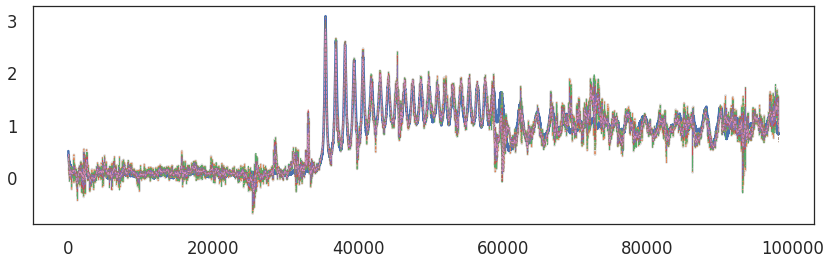

In [29]:
plt.figure(figsize=(14, 4))
plt.plot(pred, '-k', alpha=0.15)
plt.plot(r_obs[:len(v_obs)-T*d+1])
for M in (5, 10, 60, 100, 300, 500) :
    ma = savgol_filter(pred, M, polyorder=4)
    plt.plot(ma, '--', linewidth=.8)

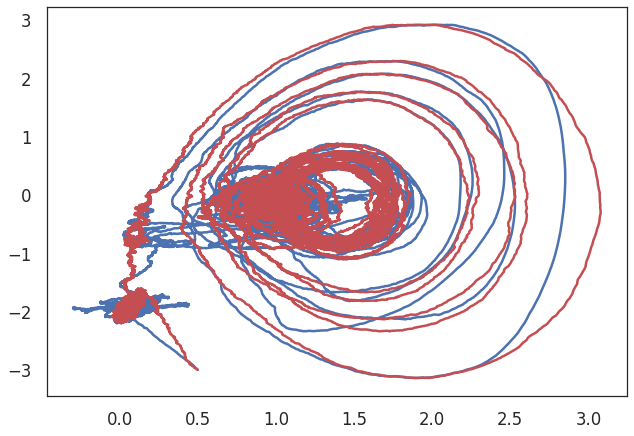

In [30]:
M=300
plt.plot(savgol_filter(pred, M, polyorder=2), v_obs[:len(v_obs)-T*d+1])
plt.plot(r_obs, v_obs, 'r')

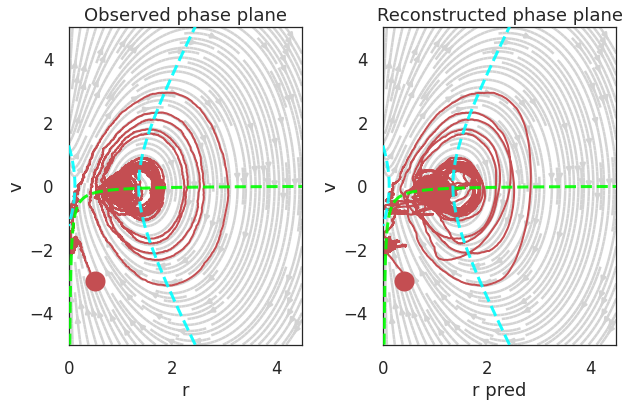

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 6))

param={"delta": data_input['delta_true'], "eta": data_input['eta_true'], "J": data_input['J_true'], 
       "I0": data_input['I0']}

plane_lim = 5
xrange = (0, plane_lim-0.5) 
yrange =(-plane_lim, plane_lim)
plot_vector_field(ax[0], param, xrange, yrange)
plot_vector_field(ax[1], param, xrange, yrange)

ax[0].plot(r_obs, v_obs, marker="o", markersize=0, lw=2, color='r', zorder=2)
ax[0].plot(r_obs[0], v_obs[0], marker="o", markersize=20, lw=0, color='r', zorder=3)
ax[0].set(xlabel='r',  ylabel='v', title="Observed phase plane")

ax[1].plot(savgol_filter(pred, M, polyorder=2), v_obs[:len(v_obs)-T*d+1], marker="o", markersize=0, lw=2, color='r', zorder=2)
ax[1].plot(pred[0], v_obs[:len(v_obs)-T*d+1][0], marker="o", markersize=20, lw=0, color='r', zorder=3)
ax[1].set(xlabel='r pred', ylabel='v',
      title="Reconstructed phase plane")
plt.tight_layout()

In [32]:
r_recons_smooth = savgol_filter(pred, M, polyorder=2)
rmse_fit = np.sqrt(mean_squared_error(z_test, r_recons_smooth))
rmse_fit

0.1514661164573085

In [33]:
data_output = {'T': T, 'd': d, 'r': list(r_obs), 'v': list(v_obs), 'r_recons': list(pred), 
               'r_recons_smooth': list(r_recons_smooth),
               'sim_sigma': sim_sigma,
               'data_sigma': data_sigma,
               'rmse_fit': rmse_fit,
               'data_input_filename': data_input_filename}
json_object = json.dumps(data_output, indent=4)
with open("results/r_recons_sigma=" + str(data_sigma) + ".json", "w") as outfile:
    outfile.write(json_object)

In [6]:
with open("results/r_recons_sigma=0.1.json", "r") as readfile :
    recons = json.load(readfile)

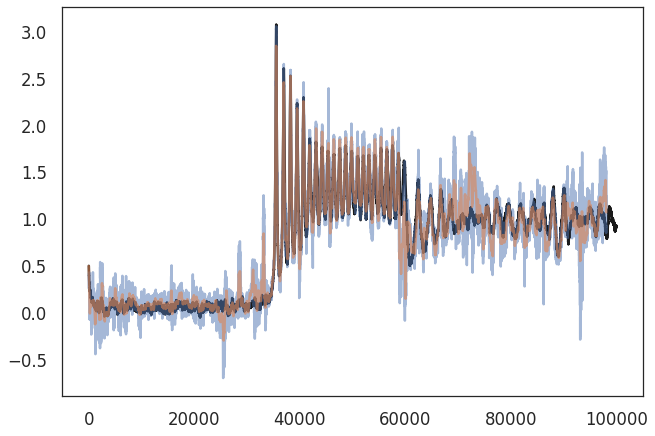

In [19]:
plt.plot(recons['r'], 'k')
plt.plot(recons['r_recons'], alpha=0.5)
plt.plot(recons['r_recons_smooth'], alpha=0.6)

In [73]:
r_rec = recons['r_recons']
r_obs = recons['r']

M = 300
center = savgol_filter(r_rec[40000:60000], M, polyorder=2)

rmse = []
for p in [1, 2, 3, 4, 5] :
    for m in [k*M for k in range(1, 10)] :
        pre = savgol_filter(r_rec[:40000], m, polyorder=p)
        post = savgol_filter(r_rec[60000:], m, polyorder=p)
        rec = list(pre) + list(center) + list(post)
        rmse.append([p, m, np.sqrt(mean_squared_error(rec, r_obs[:len(rec)]))])


In [74]:
rmse[np.argmin(np.array(rmse)[:, 2])]

[1, 300, 0.14816912863734408]

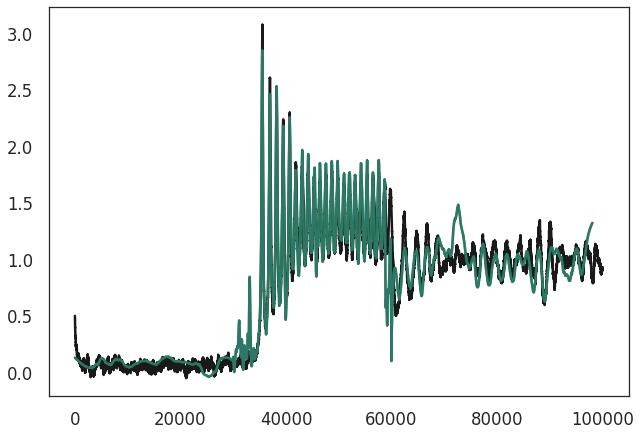

In [116]:
center = savgol_filter(r_rec[30000:60000], M, polyorder=2)
pre = savgol_filter(r_rec[:30000], 4000, polyorder=2)
post = savgol_filter(r_rec[60000:], 2000, polyorder=3)
rec = list(pre) + list(center) + list(post)

plt.plot(r_obs, 'k')
plt.plot(rec, color='green')
plt.plot(recons['r_recons_smooth'], alpha=0.6)

In [113]:
data_output = recons
data_output['r_recons_smooth'] = rec
json_object = json.dumps(data_output, indent=4)
with open("results/r_recons_split_sigma=0.1.json", "w") as outfile:
    outfile.write(json_object)